In [ ]:
!pip install rasterio==1.2.10
!pip install xarray-spatial==0.3.5
!pip install rtxpy
!pip install numba==0.55.1
!pip install geopandas
!pip install spatialpandas

# Mountain peak with best view

In this notebook, we want to identify the mountain with best view in Colorado, USA. The elevation raster used in this notebook is from the SRTM dataset. Mountain peaks data is extracted from Open Street Map. We'll use `viewshed` tool from `xarray-spatial` to calculate the visibility grids from top 20 highest peaks in Colorado and choose the peak where the most places can be seen. 

## Imports

First, let's import all necessary packages to run the notebook.

In [1]:
import pandas
import matplotlib.pyplot as plt
import geopandas as gpd

import xarray as xr
import numpy as np
import cupy

from xrspatial import hillshade
from xrspatial import viewshed

## Load data

#### Raster data

The input ***elevation raster*** data covers the state of Colorado, USA. We'll load it from a local input file and calculate its bounding box to define the study area.

In [9]:
file_name = 'colorado_merge_3arc_resamp.tif'
raster = xr.open_rasterio(file_name).sel(band=1).drop('band', dim=None)
raster.name = 'Colorado Elevation Raster'

xmin, xmax = raster.x.data.min(), raster.x.data.max()
ymin, ymax = raster.y.data.min(), raster.y.data.max()

xmin, xmax, ymin, ymax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  


(-109.99974993088883,
 -102.00025006911117,
 36.000333437166745,
 41.999666562833255)

#### Mountain peaks data

Now we'll load the ***mountain peaks*** data into a geopandas Data Frame. It contains the top 20 highest peaks within the studay area. We'll compute their visibility to decide which has the best view. 

In [3]:
top_peaks_dict = dict(
    ELEV_METER=[4397, 4393, 4393, 4391, 4373, 4369, 4360, 4359, 4354, 4354, 4351, 4348, 4347, 4347, 4346, 4343, 4343, 4338, 4335, 4327],
    NAME=[
        'Mount Elbert', 'Gannett Peak (Not Official)', 'Mount Massive', 'Mount Harvard', 'Blanca Peak',
        'La Plata Peak', 'Crestone Peak', 'Uncompahgre Peak', 'Crestone Peaks', 'Mount Lincoln',
        'Grays Peak', 'Torreys Peak', 'Quandary Peak', 'Longs Peak', 'Castle Peak',
        'Mount Antero', 'Mount Evans', 'Mount Cameron', 'Mount Shavano', 'Mount Princeton'
    ],
    lat=[
        39.11787, 39.18753, 39.18753, 38.92444, 37.57756, 39.02936, 37.96681, 38.07166, 37.96684, 39.3515,
        39.63374, 39.64269, 39.39725, 40.25486, 39.00969, 38.67405, 39.58823, 39.34635, 38.61898, 38.74915
    ],
    long=[
        -106.44526, -106.47558, -106.47558, -106.32058, -105.4856, -106.47311, -105.58539, -107.462, -105.58535, -106.11138,
        -105.81737, -105.82119, -106.1064, -105.61624, -106.86129, -106.24625, -105.64372, -106.1189, -106.23922, -106.24245
    ]
)

top_peaks = pandas.DataFrame.from_dict(top_peaks_dict).astype({'NAME': str, 'ELEV_METER':int, 'long':float, 'lat':float})
top_peaks = gpd.GeoDataFrame(top_peaks, geometry=gpd.points_from_xy(top_peaks.long, top_peaks.lat))
top_peaks

,ELEV_METER,NAME,lat,long,geometry
0,4397,Mount Elbert,39.11787,-106.44526,POINT (-106.44526 39.11787)
1,4393,Gannett Peak (Not Official),39.18753,-106.47558,POINT (-106.47558 39.18753)
2,4393,Mount Massive,39.18753,-106.47558,POINT (-106.47558 39.18753)
3,4391,Mount Harvard,38.92444,-106.32058,POINT (-106.32058 38.92444)
4,4373,Blanca Peak,37.57756,-105.48560,POINT (-105.48560 37.57756)
5,4369,La Plata Peak,39.02936,-106.47311,POINT (-106.47311 39.02936)
6,4360,Crestone Peak,37.96681,-105.58539,POINT (-105.58539 37.96681)
7,4359,Uncompahgre Peak,38.07166,-107.46200,POINT (-107.46200 38.07166)
8,4354,Crestone Peaks,37.96684,-105.58535,POINT (-105.58535 37.96684)
9,4354,Mount Lincoln,39.35150,-106.11138,POINT (-106.11138 39.35150)


#### Visualize input data

We'll compute hillshade of the raster to better understand it.

In [4]:
illuminated = hillshade(raster, name='Hillshade')

Visualize both input raster and the illuminated hillshade.

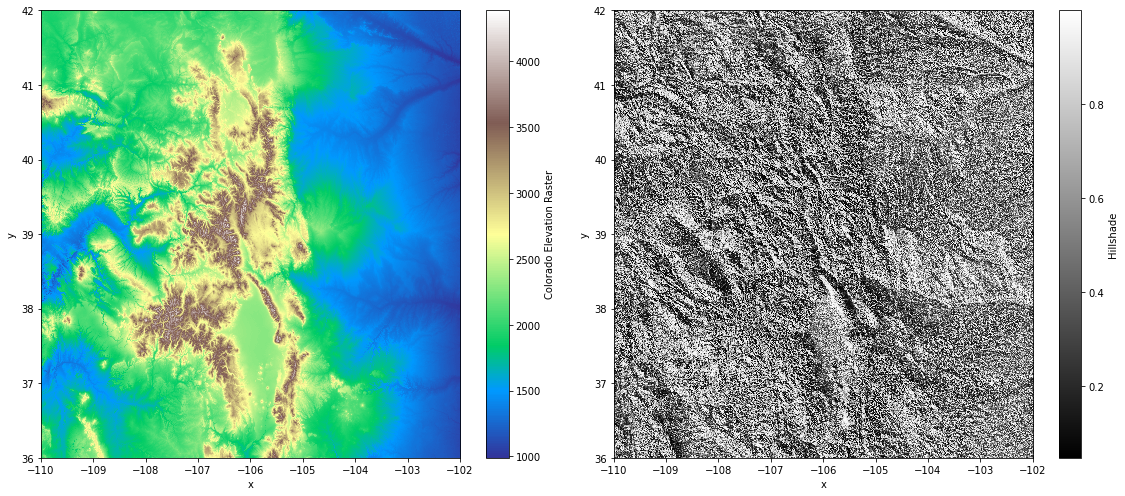

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
raster.plot.imshow(ax=ax1, cmap='terrain')
illuminated.plot.imshow(ax=ax2, cmap='gray')
plt.tight_layout()

Add points that representing the select mountain peaks with red color.

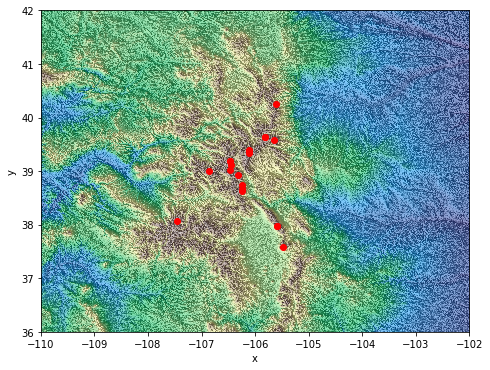

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
illuminated.plot.imshow(ax=ax, cmap='gray')
raster.plot.imshow(ax=ax, cmap='terrain', alpha=0.5)
top_peaks.plot(ax=ax, color='red')
# drop color bars
plt.delaxes(fig.axes[-1])
plt.delaxes(fig.axes[-1])

## Transfer data to GPU

We'll transfer the raster data to the GPU to run viewshed more quickly.

In [11]:
raster.data = cupy.asarray(raster.data)
raster

<xarray.DataArray 'Colorado Elevation Raster' (y: 4000, x: 6000)>
array([[1957., 1956., 1955., ..., 1175., 1174., 1174.],
       [1958., 1957., 1957., ..., 1178., 1177., 1178.],
       [1957., 1954., 1953., ..., 1195., 1192., 1187.],
       ...,
       [2046., 2031., 2020., ..., 1109., 1109., 1107.],
       [2028., 2024., 2019., ..., 1112., 1112., 1107.],
       [2003., 2005., 2006., ..., 1109., 1110., 1108.]], dtype=float32)
Coordinates:
  * y        (y) float64 42.0 42.0 42.0 42.0 41.99 ... 36.01 36.0 36.0 36.0 36.0
  * x        (x) float64 -110.0 -110.0 -110.0 -110.0 ... -102.0 -102.0 -102.0
Attributes:
    transform:      (0.0013334722223333321, 0.0, -110.000416667, 0.0, -0.0015...
    crs:            +init=epsg:4326
    res:            (0.0013334722223333321, 0.0015002083335000015)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

## Calculate visibility

For each selected point in top 20 highest peaks, we'll calculate their visibility with `xrspatial.viewshed` and compute the areas that can be seen from that point. Mountain peak with largest visibility area is the mountain with best view.

In [12]:
# invisible points from a view point are marked as -1 in the output visibility grid
INVISIBLE = -1
# let's now define visible points as 1
VISIBLE = 1

visibility_grids = []

for i, peak in top_peaks.iterrows():
    viewpoint_x, viewpoint_y = peak['geometry'].x, peak['geometry'].y
    viewshed_grid = viewshed(raster, x=viewpoint_x, y=viewpoint_y)
    # assign name for the output grid
    viewshed_grid.name = peak['NAME']
    # set visible cells to VISIBLE
    viewshed_grid = viewshed_grid.where(viewshed_grid == INVISIBLE, other=VISIBLE)
    visibility_grids.append(viewshed_grid)

Visualize the output results of all viewpoints.

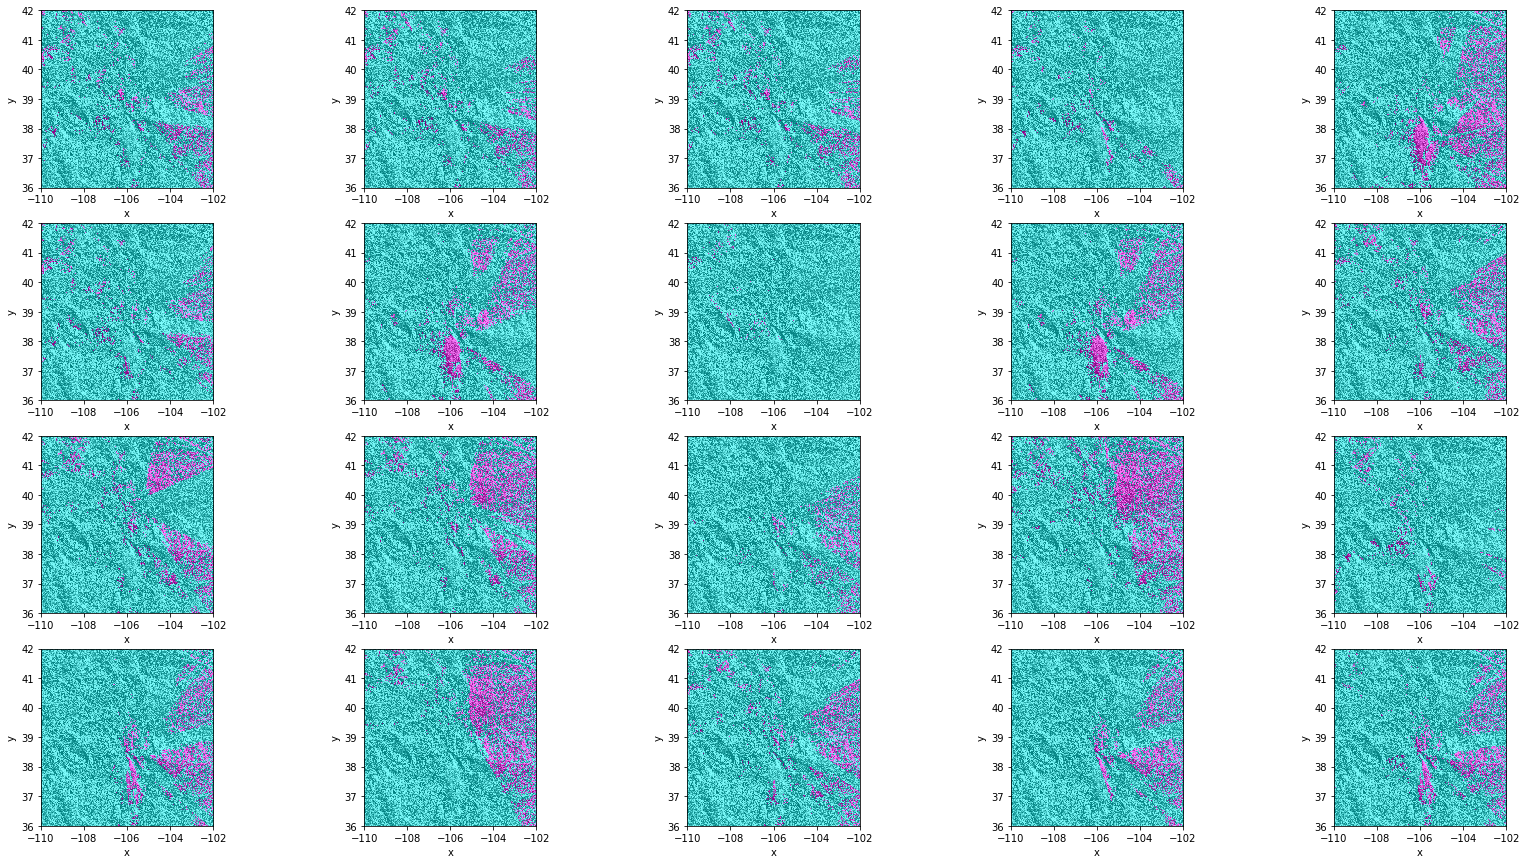

In [13]:
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(28, 15))
for i in range(nrows):
    for j in range(ncols):
        grid_id = i*ncols + j
        illuminated.plot.imshow(ax=axes[i][j], cmap='gray')
        visibility_grids[grid_id].plot.imshow(ax=axes[i][j], alpha=0.5, cmap='cool')
        plt.delaxes(fig.axes[-1])
        plt.delaxes(fig.axes[-1])

## Best view mountain peak

From the results above, we can identify the mountain peak with best view.

In [14]:
visibility_areas = np.array([len(cupy.where(v.data != INVISIBLE)[0]) for v in visibility_grids])
best_peak_id = np.argmax(visibility_areas)

top_peaks.iloc[best_peak_id]

ELEV_METER                           4347
NAME                           Longs Peak
lat                              40.25486
long                           -105.61624
geometry      POINT (-105.61624 40.25486)
Name: 13, dtype: object

#### Visualize the output result

Highlight the location with best view using dark red color.

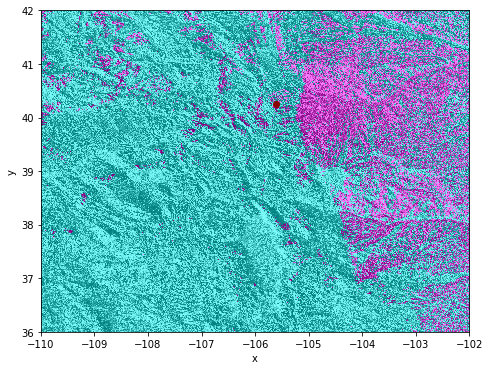

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
illuminated.plot.imshow(ax=ax, cmap='gray')
visibility_grids[best_peak_id].plot.imshow(ax=ax, alpha=0.5, cmap='cool')
top_peaks.iloc[[best_peak_id]].plot(ax=ax, color='darkred')

# drop color bars
plt.delaxes(fig.axes[-1])
plt.delaxes(fig.axes[-1])